# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [1]:
# relevant imports
import os
from torch import nn, optim
from torchsummary import summary
from datasets import load_dataset
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from ray.train import Checkpoint
from monai.losses import DiceLoss
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from ray.air import session
from pathlib import Path
import torch
from monai.metrics import MeanIoU
from monai.transforms import Activations, AsDiscrete

#### Modelarchitecture
![segnet_graph.png](https://production-media.paperswithcode.com/methods/segnet_Vorazx7.png)


In [2]:
class SegNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SegNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = SegNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_2 = SegNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_3 = SegNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_4 = SegNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        self.bottle_neck_block_1 = SegNet._conv_block(256, 512)
        self.max_pool_5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # Decoder Blocks
        self.decoder_block_5 = SegNet._conv_block(512, 256)

        self.unpool_block_4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_4 = SegNet._conv_block(256, 128)

        self.unpool_block_3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_3 = SegNet._conv_block(128, 64)

        self.unpool_block_2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_2 = SegNet._conv_block(64, 32)

        self.unpool_block_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_1 = SegNet._conv_block(32, 32)

        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e1_1, i1 = self.max_pool_1(e1)

        e2 = self.encoder_block_2(e1_1)
        e2_1, i2 = self.max_pool_2(e2)

        e3 = self.encoder_block_3(e2_1)
        e3_1, i3 = self.max_pool_3(e3)

        e4 = self.encoder_block_4(e3_1)
        e4_1, i4 = self.max_pool_4(e4)

        b = self.bottle_neck_block_1(e4_1)
        b, i5 = self.max_pool_5(b)
        b_unpool = self.max_unpool(b, i5)
        b = self.decoder_block_5(b_unpool)

        d4 = self.unpool_block_4(b, i4)
        d4 = self.decoder_block_4(d4)

        d3 = self.unpool_block_3(d4, i3)
        d3 = self.decoder_block_3(d3)

        d2 = self.unpool_block_2(d3, i2)
        d2 = self.decoder_block_2(d2)

        d1 = self.unpool_block_1(d2, i1)
        d1 = self.decoder_block_1(d1)

        return self.fc(d1)


    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

In [3]:
segnet = SegNet(3, 1)
segnet.cuda()
summary(segnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7  [[-1, 32, 128, 128], [-1, 32, 128, 128]]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14  [[

---

#### Datapreparation

In [3]:
isic18_dataset = load_dataset("surajbijjahalli/ISIC2018")
isic18_dataset

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2594
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [4]:
class ISICDataset(Dataset):
    def __init__(self, dataset, transform_image=None, transform_mask=None):
        self.dataset = dataset
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        image = example['image']
        mask = example['label']
        mask = mask.convert('L')
        mask = np.array(mask)
        mask[mask > 0] = 255
        mask[mask == 0] = 0
        mask = Image.fromarray(mask)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [5]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()])

isic18_train_dataset = ISICDataset(isic18_dataset['train'], transform_image, transform_mask)
isic18_val_dataset = ISICDataset(isic18_dataset['validation'], transform_image, transform_mask)
isic18_test_dataset = ISICDataset(isic18_dataset['test'], transform_image, transform_mask)

---

#### Training

In [7]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss

In [8]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss

In [10]:
def train_segnet(
        config: dict,
        train_dataset: datasets,
        validation_dataset: datasets,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = SegNet(3, 1).to(device)

    loss_fn = DiceLoss(sigmoid=True)

    optim_params: dict = {
        'lr': config["lr"]
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

    scheduler_params: dict = {
        'gamma': config['gamma'],
        'verbose': False
    }
    scheduler: ExponentialLR = ExponentialLR(optimizer, **scheduler_params)

    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Training with parameter

In [11]:
config = {'lr': 0.0011075820407299578, 'gamma': 0.9596539000640568}

res = train_segnet(config, isic18_train_dataset, isic18_val_dataset, 50, return_flag=True, apply_scheduler=True)

cuda:1


/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Start training...


  0%|          | 0/50 [00:00<?, ?it/s]

Start:  0


/home/jovyan/.local/lib/python3.11/site-packages/ray/train/_internal/session.py:652: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(
  2%|▏         | 1/50 [02:18<1:53:24, 138.88s/it]

0  -  tr_loss: 0.5703063054782588 val_loss: 0.44001592695713043
Start:  1
1  -  tr_loss: 0.4575370150368388 val_loss: 0.4440404325723648


  4%|▍         | 2/50 [04:48<1:56:11, 145.24s/it]

Start:  2
2  -  tr_loss: 0.37724038231663587 val_loss: 0.43178193271160126


  6%|▌         | 3/50 [07:12<1:53:28, 144.87s/it]

Start:  3
3  -  tr_loss: 0.3207658820035981 val_loss: 0.29853230714797974


  8%|▊         | 4/50 [09:34<1:49:57, 143.43s/it]

Start:  4
4  -  tr_loss: 0.2679170144767296 val_loss: 0.23473630845546722


 10%|█         | 5/50 [11:56<1:47:21, 143.14s/it]

Start:  5
5  -  tr_loss: 0.22833247773531007 val_loss: 0.2837586849927902


 12%|█▏        | 6/50 [14:22<1:45:30, 143.88s/it]

Start:  6
6  -  tr_loss: 0.20844196110236934 val_loss: 0.1931348443031311


 14%|█▍        | 7/50 [16:42<1:42:23, 142.87s/it]

Start:  7
7  -  tr_loss: 0.1934820540794512 val_loss: 0.20949213951826096


 16%|█▌        | 8/50 [19:05<1:39:57, 142.80s/it]

Start:  8
8  -  tr_loss: 0.18376935364269628 val_loss: 0.17874283343553543


 18%|█▊        | 9/50 [21:20<1:35:51, 140.29s/it]

Start:  9
9  -  tr_loss: 0.16930969822697522 val_loss: 0.19473837316036224


 20%|██        | 10/50 [23:51<1:35:49, 143.73s/it]

Start:  10
10  -  tr_loss: 0.1598866311151807 val_loss: 0.17598292976617813


 22%|██▏       | 11/50 [26:31<1:36:40, 148.72s/it]

Start:  11
11  -  tr_loss: 0.1560004942300843 val_loss: 0.1664091944694519


 24%|██▍       | 12/50 [29:13<1:36:44, 152.76s/it]

Start:  12
12  -  tr_loss: 0.15079773780776234 val_loss: 0.17874276638031006


 26%|██▌       | 13/50 [31:44<1:33:46, 152.06s/it]

Start:  13
13  -  tr_loss: 0.1491745534103091 val_loss: 0.16074209660291672


 28%|██▊       | 14/50 [34:20<1:32:04, 153.45s/it]

Start:  14
14  -  tr_loss: 0.14293806018625818 val_loss: 0.16193556040525436


 30%|███       | 15/50 [36:38<1:26:38, 148.54s/it]

Start:  15


 32%|███▏      | 16/50 [39:06<1:24:04, 148.38s/it]

15  -  tr_loss: 0.14632142353348615 val_loss: 0.15491712093353271
Start:  16
16  -  tr_loss: 0.1411176547408104 val_loss: 0.15111027657985687


 34%|███▍      | 17/50 [41:26<1:20:16, 145.96s/it]

Start:  17
17  -  tr_loss: 0.13394212613745435 val_loss: 0.1580248400568962


 36%|███▌      | 18/50 [43:49<1:17:18, 144.94s/it]

Start:  18
18  -  tr_loss: 0.13406489971207408 val_loss: 0.14964031428098679


 38%|███▊      | 19/50 [46:02<1:13:08, 141.56s/it]

Start:  19
19  -  tr_loss: 0.13160399293027272 val_loss: 0.1636941060423851


 40%|████      | 20/50 [48:39<1:13:07, 146.24s/it]

Start:  20
20  -  tr_loss: 0.13050610499411094 val_loss: 0.1457522064447403


 42%|████▏     | 21/50 [51:21<1:12:56, 150.92s/it]

Start:  21
21  -  tr_loss: 0.12869355391438414 val_loss: 0.14686663448810577


 44%|████▍     | 22/50 [53:43<1:09:11, 148.28s/it]

Start:  22
22  -  tr_loss: 0.1241945653426938 val_loss: 0.14967315644025803


 46%|████▌     | 23/50 [56:00<1:05:05, 144.66s/it]

Start:  23
23  -  tr_loss: 0.12044738632876699 val_loss: 0.15159405767917633


 48%|████▊     | 24/50 [58:12<1:01:04, 140.93s/it]

Start:  24
24  -  tr_loss: 0.11697331652408693 val_loss: 0.13619783520698547


 50%|█████     | 25/50 [1:00:53<1:01:13, 146.94s/it]

Start:  25
25  -  tr_loss: 0.11419936124144531 val_loss: 0.14906954020261765


 52%|█████▏    | 26/50 [1:03:46<1:01:53, 154.72s/it]

Start:  26
26  -  tr_loss: 0.11391324640774145 val_loss: 0.14684009552001953


 54%|█████▍    | 27/50 [1:05:59<56:54, 148.46s/it]  

Start:  27
27  -  tr_loss: 0.11455966822984742 val_loss: 0.13923052698373795


 56%|█████▌    | 28/50 [1:08:17<53:14, 145.19s/it]

Start:  28
28  -  tr_loss: 0.10689212854315595 val_loss: 0.14206691831350327


 58%|█████▊    | 29/50 [1:10:41<50:39, 144.73s/it]

Start:  29
29  -  tr_loss: 0.10777041497753888 val_loss: 0.1418241709470749


 60%|██████    | 30/50 [1:13:01<47:45, 143.27s/it]

Start:  30
30  -  tr_loss: 0.10624807945838789 val_loss: 0.14240141957998276


 62%|██████▏   | 31/50 [1:15:21<45:05, 142.38s/it]

Start:  31
31  -  tr_loss: 0.10454165299491185 val_loss: 0.14086058735847473


 64%|██████▍   | 32/50 [1:17:40<42:22, 141.28s/it]

Start:  32
32  -  tr_loss: 0.10407892923529555 val_loss: 0.1490333378314972


 66%|██████▌   | 33/50 [1:19:55<39:33, 139.62s/it]

Start:  33
33  -  tr_loss: 0.09940999146641755 val_loss: 0.1382712498307228


 68%|██████▊   | 34/50 [1:22:23<37:54, 142.13s/it]

Start:  34
34  -  tr_loss: 0.09945426317976742 val_loss: 0.13385694473981857


 70%|███████   | 35/50 [1:24:53<36:07, 144.50s/it]

Start:  35
35  -  tr_loss: 0.09784254958716834 val_loss: 0.1412922441959381


 72%|███████▏  | 36/50 [1:27:15<33:33, 143.80s/it]

Start:  36
36  -  tr_loss: 0.09666014462709427 val_loss: 0.14412381500005722


 74%|███████▍  | 37/50 [1:29:31<30:38, 141.41s/it]

Start:  37
37  -  tr_loss: 0.09370466121813147 val_loss: 0.14100245386362076


 76%|███████▌  | 38/50 [1:31:53<28:17, 141.43s/it]

Start:  38
38  -  tr_loss: 0.09277751678373755 val_loss: 0.13266298919916153


 78%|███████▊  | 39/50 [1:34:15<25:57, 141.56s/it]

Start:  39
39  -  tr_loss: 0.0922134683989897 val_loss: 0.14247935265302658


 80%|████████  | 40/50 [1:36:28<23:12, 139.21s/it]

Start:  40
40  -  tr_loss: 0.090138439725085 val_loss: 0.13684289902448654


 82%|████████▏ | 41/50 [1:38:47<20:51, 139.04s/it]

Start:  41
41  -  tr_loss: 0.08675445489040236 val_loss: 0.14961974322795868


 84%|████████▍ | 42/50 [1:41:09<18:39, 139.89s/it]

Start:  42
42  -  tr_loss: 0.09311962636505686 val_loss: 0.13883060216903687


 86%|████████▌ | 43/50 [1:43:33<16:28, 141.24s/it]

Start:  43
43  -  tr_loss: 0.08749626140768935 val_loss: 0.14492063969373703


 88%|████████▊ | 44/50 [1:46:03<14:23, 143.84s/it]

Start:  44
44  -  tr_loss: 0.08536588745873148 val_loss: 0.14243730157613754


 90%|█████████ | 45/50 [1:48:37<12:13, 146.75s/it]

Start:  45
45  -  tr_loss: 0.08132289858852945 val_loss: 0.13159330934286118


 92%|█████████▏| 46/50 [1:50:58<09:40, 145.17s/it]

Start:  46
46  -  tr_loss: 0.0790290871589649 val_loss: 0.14448846876621246


 94%|█████████▍| 47/50 [1:53:24<07:16, 145.46s/it]

Start:  47
47  -  tr_loss: 0.07903326847931234 val_loss: 0.13683921843767166


 96%|█████████▌| 48/50 [1:55:45<04:48, 144.05s/it]

Start:  48
48  -  tr_loss: 0.07747405812871165 val_loss: 0.14211881905794144


 98%|█████████▊| 49/50 [1:58:34<02:31, 151.59s/it]

Start:  49
49  -  tr_loss: 0.07653737658771073 val_loss: 0.13851062953472137


100%|██████████| 50/50 [2:00:58<00:00, 145.16s/it]


In [12]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

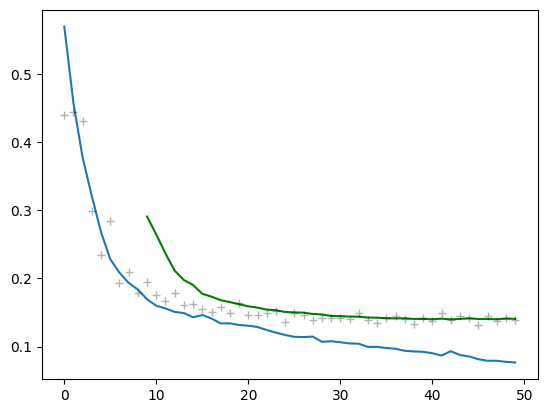

In [13]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [15]:
torch.save(model, '../../res/checkpoints/segnet_isic18_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/segnet_isic18.pt')

In [8]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [9]:
test_dataloader = DataLoader(isic18_test_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = SegNet(3, 1).to(device)

net = load_checkpoint(Path('../../res/checkpoints/segnet_isic18.pt'), net)

In [9]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy for binary segmentation.
    :param model: neural network
    :param data_loader: torch Dataloader
    :param device: device on which to perform the evaluation
    :return: None
    """
    total_correct_pixels = 0
    total_pixels = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).cpu().numpy()

            targets = targets.numpy().flatten()
            preds = preds.flatten()

            correct_pixels = np.sum(preds == targets)
            total_pixels += targets.size
            total_correct_pixels += correct_pixels

    pixel_accuracy = total_correct_pixels / total_pixels
    print('Pixel Accuracy: ', pixel_accuracy)

In [10]:
evaluate_model(net, test_dataloader, device)

100%|██████████| 16/16 [03:07<00:00, 11.72s/it]

Pixel Accuracy:  0.9131194610595703


In [11]:
def evaluate_binary_mean_iou(model, dataloader, device) -> float:
    """
    Evaluate the Mean IoU for binary segmentation.
    :param model: neural network
    :param dataloader: Torch Dataloader
    :param device: device on which to perform the evaluation
    :return: mean IoU
    """
    mean_iou_metric = MeanIoU(include_background=True, reduction="mean")
    activation = Activations(sigmoid=True)
    discretize = AsDiscrete(threshold=0.5)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            preds = activation(outputs)
            preds = discretize(preds)

            mean_iou_metric(y_pred=preds, y=targets)

    mean_iou = mean_iou_metric.aggregate().item()
    print(f"Mean IoU: {mean_iou}")
    return mean_iou


In [12]:
evaluate_binary_mean_iou(net, test_dataloader, device)

100%|██████████| 16/16 [02:51<00:00, 10.72s/it]

Mean IoU: 0.7625640630722046


0.7625640630722046